In [1]:
import os
import sys
import multiprocessing as mp
import pickle
from pathlib import Path
import wandb
import torch
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

In [2]:
%load_ext autoreload
%autoreload 2

# Load model as artifact from WandB

In [2]:
run = wandb.init()
#artifact = run.use_artifact('asm_detect/ASM_seg/model-z1woyme2:v18', type='model')
#artifact = run.use_artifact('asm_detect/ASM_seg/model-ztyg139f:v19', type='model')
artifact = run.use_artifact('asm_detect/ASM_seg/model-h2a1y1vd:v19', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kayan (asm_detect). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-h2a1y1vd:v19, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.8


In [3]:
print(artifact_dir)

/n/home07/kayan/asm/notebooks/artifacts/model-h2a1y1vd:v19


In [3]:
#artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-z1woyme2:v19"
#artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-ztyg139f:v19"
artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-h2a1y1vd:v19"

In [4]:
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]

In [5]:
# model parameters
lr = 1e-5
loss = "ce"
class_weights = [0.2,0.8]
freeze_backbone = False

task_unet = CustomSemanticSegmentationTask(
    model="unet",
    backbone="resnet18",
    weights=True,
    loss=loss,
    class_weights = torch.Tensor(class_weights),
    in_channels=4,
    num_classes=2,
    lr=lr,
    patience=5,
    freeze_backbone=freeze_backbone,
    freeze_decoder=False
)

task_unet.load_state_dict(state_dict)

<All keys matched successfully>

# Set up dataloaders

In [6]:
# Put model on evaluation mode and load to local device
task_unet.eval()

device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
workers = len(os.sched_getaffinity(0))
task_unet = task_unet.to(device)

In [19]:
# datamodule parameters
root = "/n/holyscratch01/tambe_lab/kayan/karena/"
batch_size = 1#batch_size = 64
num_workers = workers
mines_only = False
split = False
split_n = None
split_path = "/n/home07/kayan/asm/data/splits/9_all_data_lowlr_save-split"
save_split = False

In [20]:
# get test dataloader from datamodule
datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                           root=root, transforms=None, mines_only=mines_only, split_path=split_path)
#datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
#                           root=root, transforms=min_max_transform, mines_only=mines_only, split_path=split_path)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()

In [ ]:
for idx,samples in enumerate(train_dataloader):
    unique_ids = samples['id']
    if idx==2: break

In [ ]:
unique_ids

# Run inference

In [ ]:
# train dataset
pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(train_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = task_unet(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}", end =" ")

In [ ]:
# test dataset
test_pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = task_unet(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            test_pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

In [ ]:
# save segmentation output for train and test datasets
data_dir = "/n/home07/kayan/asm/data/"
with open(data_dir+"train_seg_preds", 'wb') as handle:
    pickle.dump(pixelwise_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_dir+"test_seg_preds", 'wb') as handle:
    pickle.dump(test_pixelwise_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load previously saved segmentation model output

In [ ]:
data_dir = "/n/home07/kayan/asm/data/"
with open(data_dir+"train_seg_preds", 'rb') as handle:
    pixelwise_preds = pickle.load(handle)
with open(data_dir+"test_seg_preds", 'wb') as handle:
    test_pixelwise_preds = pickle.load(handle)

# Train convolutional layer

In [162]:
# training parameters
batch_size = 32
lr = 0.001
n_epoch = 5
class_weights = torch.Tensor([0.2,0.8]).to(device)

In [145]:
# wandb logging info
project = "ASM_seg_conv" # project name in WandB
run_name = "0_test"

In [146]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in pixelwise_predictions.keys()]

In [147]:
inputs = np.array(list(pixelwise_predictions.values()))

In [148]:
tensor_inputs = torch.Tensor(inputs)
tensor_inputs = tensor_inputs[:, None, :, :]
tensor_labels = torch.LongTensor(labels)

In [149]:
dataset = TensorDataset(tensor_inputs,tensor_labels)

In [150]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [151]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

conv_model = ConvNet().to(device)

In [152]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(conv_model.parameters(), lr=lr)

In [153]:
#wandb.init(project=project, name=run_name, save_code=True)

In [154]:
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = conv_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #wandb.log({'training_loss': running_loss / 100})
            running_loss = 0.0

# Test performance

In [72]:
test_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] 
               for x in test_pixelwise_predictions.keys()]

In [73]:
test_inputs = np.array(list(test_pixelwise_predictions.values()))

In [74]:
tensor_test_inputs = torch.Tensor(test_inputs)
tensor_test_inputs = tensor_test_inputs[:, None, :, :]
tensor_test_labels = torch.LongTensor(test_labels)

In [139]:
test_dataset_conv = TensorDataset(tensor_test_inputs,tensor_test_labels)

In [157]:
test_dataloader_conv = DataLoader(test_dataset_conv, batch_size=batch_size)

In [158]:
class_proba = []
true_labels = []
for i, (images, labels) in enumerate(test_dataloader_conv):
    images = images.to(device)
    outputs = torch.softmax(conv_model(images),dim=-1).cpu().detach()
    class_proba.extend(outputs[:,1].tolist())
    true_labels.extend(labels.tolist())

# ROC Curve

Text(0, 0.5, 'True Positive')

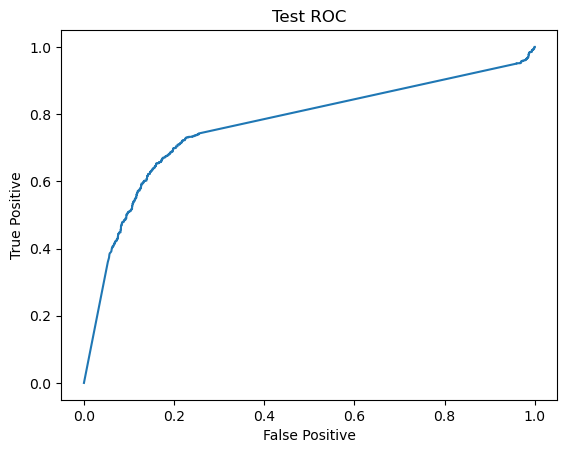

In [159]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [160]:
roc_auc_score(true_labels, class_proba)

0.7677522124973502

In [81]:
def pixelwise_to_prob(pixelwise_preds):
    class_proba = {}
    for (unique_id,preds) in pixelwise_preds.items():
        # average probability
        class_proba[unique_id] = np.mean(preds)
        #class_proba[unique_id] = np.mean(preds*(preds>0.5))
        #class_proba[unique_id] = np.sum((preds>0.5))
    return class_proba

In [82]:
class_proba = pixelwise_to_prob(test_pixelwise_predictions)

In [83]:
true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [84]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

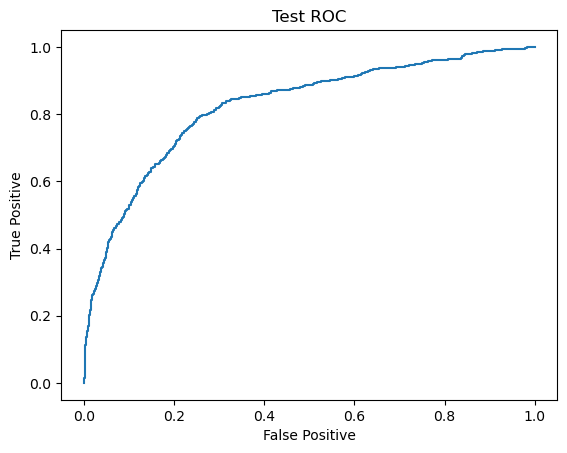

In [85]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [86]:
roc_auc_score(true_labels, class_proba)

0.823870265225169